## Determining trends in hazardous weather - red flag warning frequency

A "Red Flag Warning" is a weather event where the following conditions are met over the course of a day:

1. a sustained wind average 15 mph or greater
2. relative humidity less than or equal to 25 percent and 
3. a temperature of greater than 75 degrees F. 


We will use MACA climate datasets for this task.  These datasets are available at https://climate.northwestknowledge.net/MACA/data_csv.php (CSV format) for specific locations.  THese datasets contain many climate variables; we will want the data corresponding to the Red Flag Warning criteria above: 1) wind speed, 2) relative humidity, 3) air temperature. 

**Task 1**.  Go to the website above and download a) historic, and b) RCP8 future, daily climate data for Corvallis, OR (Lat: 44.5706N, Long: 123.2607E). Specify that six variables are requested, and use the MACAv2METDATA/GFDL-ESM2M results.  The four variables include: 
1. uas (Eastward Wind Component)
2. vas (Nortward Wind Component)
3. rhsmin (Min Relative Humidity)
4. rhsmax (Max Relative Humidity)
5. tasmin (Min Air Temperature)
6. tasmax (Max Air Temperature)

This will result in two CSV files, one for the historic period (1950-2006), one for an estimated future scenario 2006-2099.

**Task 2**.  Write a python program that 



Index(['yyyy-mm-dd', 'uas_GFDL-ESM2M_historical(ms-1)',
       'vas_GFDL-ESM2M_historical(ms-1)', 'rhsmin_GFDL-ESM2M_historical(%)',
       'rhsmax_GFDL-ESM2M_historical(%)', 'tasmin_GFDL-ESM2M_historical(K)',
       'tasmax_GFDL-ESM2M_historical(K)'],
      dtype='object')
Mean daily air temp for period 1950-2006:      52.8 F
Mean daily wind speed for period 1950-2006:    9.5 mph
Mean relative humidities for period 1950-2006: 72.1 %
Average annual Red Flag Days:                  0.2
% of Failures (Windspeed): 66.3%
% of Failures (Temp): 98.9%
% of Failures (RH): 98.5%


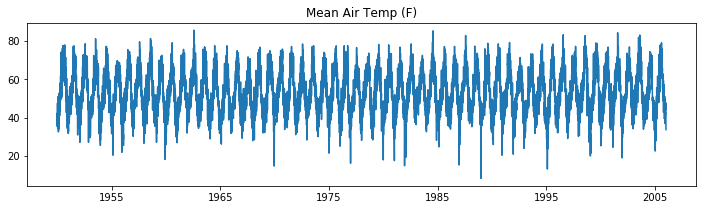

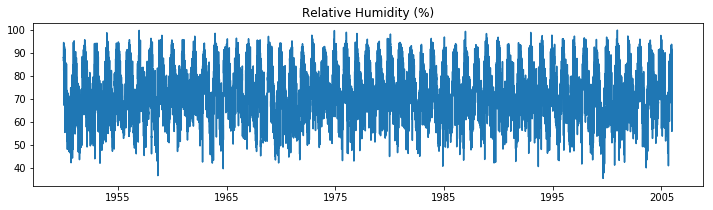

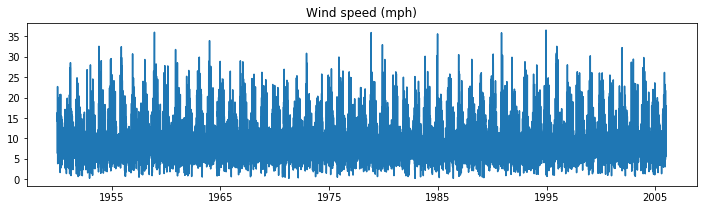

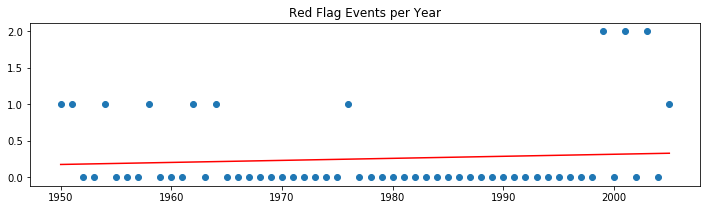

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

def CtoF(degreeC):
    return (9.0/5.0)*degreeC + 32

def MPStoMiPH(mps):
    return 2.237*mps


thWindspeed = 10  # mph
thTemp      = 75  # degrees F
thRH        = 50  # percent

df = pd.read_csv( 'http://explorer.bee.oregonstate.edu/Topic/Modeling/Data/MACA-1950-2006-Corvallis.csv',skiprows=18, 
                parse_dates=['yyyy-mm-dd'])
#df
print( df.columns)

times = df['yyyy-mm-dd']    # these will be DateTime objects!

# calculate mean daily values
meanTemps = (df['tasmin_GFDL-ESM2M_historical(K)'].values + df['tasmax_GFDL-ESM2M_historical(K)'].values )/2   # K
meanTemps = meanTemps-273.15   # kelvin to celsius 
meanTemps = CtoF(meanTemps)    # celsius to fahrenheit

plt.figure( figsize=(12,3) )
plt.title ("Mean Air Temp (F)")
plt.plot( times, meanTemps)

# calculate mean daily  relative humidity (%)
meanRHs = (df['rhsmin_GFDL-ESM2M_historical(%)'].values + df['rhsmax_GFDL-ESM2M_historical(%)'].values)/2   # K

plt.figure( figsize=(12,3) )
plt.title ("Relative Humidity (%)")
plt.plot( times, meanRHs)

# calculate wind speed (vector)
windspeeds = np.sqrt(df['uas_GFDL-ESM2M_historical(ms-1)'].values**2 + df['vas_GFDL-ESM2M_historical(ms-1)'].values**2 )   # m/s
windspeeds = MPStoMiPH(windspeeds)   # m/s to mph

plt.figure( figsize=(12,3) )
plt.title ("Wind speed (mph)")
plt.plot( times, windspeeds)

# we have what we need to find red flag days, so do it.  To simplify things, we start
# by pulling out the individual day/month/year values from the DateTime column
days   = times.dt.day
months = times.dt.month
years  = times.dt.year

# option 1 - for loop.  We will report by month, so we will accumulate count by months and months
yearList = []    
countList = []
currentYear = -1

nFailedWindspeed = 0
nFailedTemp = 0
nFailedRH = 0

for i in range(0, len(times)):
    # are we in a new month?
    if currentYear != years[i]:
        currentYear = years[i]
        yearList.append(currentYear)
        countList.append(0)
        
    if windspeeds[i] > thWindspeed and meanTemps[i] > thTemp and meanRHs[i] < thRH:
        countList[-1] = countList[-1]+1

    if windspeeds[i] <= thWindspeed:
        nFailedWindspeed += 1
        
    if  meanTemps[i] <= thTemp:
        nFailedTemp += 1
        
    if meanRHs[i] >= thRH:
        nFailedRH += 1
        
# regress the data
coefficients  = np.polyfit(yearList, countList, 1)    # solve the first order polynomial - returns list of coefficients

# calculate additional stats  For this, we will need to get some modeled results.
f = np.poly1d( coefficients )    # make a function that contains the regressed model
y = f([years.min(), years.max()] )            # apply the model to the observed days

        
# plot red flag days per year
plt.figure( figsize=(12,3) )
plt.title ("Red Flag Events per Year")
plt.scatter( yearList, countList )
plt.plot([years.min(), years.max()],y, color='red')

print( "Mean daily air temp for period 1950-2006:      {:.1f} F".format(meanTemps.mean()))
print( "Mean daily wind speed for period 1950-2006:    {:.1f} mph".format(windspeeds.mean()))
print( "Mean relative humidities for period 1950-2006: {:.1f} %".format(meanRHs.mean()))
print( "Average annual Red Flag Days:                  {:.1f}".format(np.sum(countList)/len(yearList)))

print( "% of Failures (Windspeed): {:.1f}%".format(100*nFailedWindspeed/len(times)))
print( "% of Failures (Temp): {:.1f}%".format(100*nFailedTemp/len(times)))
print( "% of Failures (RH): {:.1f}%".format(100*nFailedRH/len(times)))


### Repeat for the period 2006-2099. 

These results are based on the GFDL-ESM2M model predictions for the RC8.5 emmision scenario.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

df = pd.read_csv( 'http://explorer.bee.oregonstate.edu/Topic/Modeling/Data/MACA-2006-2099-Corvallis.csv',skiprows=18, 
                parse_dates=['yyyy-mm-dd'])
#df
print( df.columns)

times = df['yyyy-mm-dd']    # these will be DateTime objects!

# calculate mean daily values
meanTemps = (df['tasmin_GFDL-ESM2M_rcp85(K)'].values + df['tasmax_GFDL-ESM2M_rcp85(K)'].values )/2   # K
meanTemps = meanTemps-273.15   # kelvin to celsius 
meanTemps = CtoF(meanTemps)    # celsius to fahrenheit

plt.figure( figsize=(12,3) )
plt.title ("Mean Air Temp (F)")
plt.plot( times, meanTemps)

# calculate mean daily  relative humidity (%)
meanRHs = (df['rhsmin_GFDL-ESM2M_rcp85(%)'].values + df['rhsmax_GFDL-ESM2M_rcp85(%)'].values)/2   # K

plt.figure( figsize=(12,3) )
plt.title ("Relative Humidity (%)")
plt.plot( times, meanRHs)

# calculate wind speed (vector)
windspeeds = np.sqrt(df['uas_GFDL-ESM2M_rcp85(ms-1)'].values**2 + df['vas_GFDL-ESM2M_rcp85(ms-1)'].values**2 )   # m/s
windspeeds = MPStoMiPH(windspeeds)   # m/s to mph

plt.figure( figsize=(12,3) )
plt.title ("Wind speed (mph)")
plt.plot( times, windspeeds)

# we have what we need to find red flag days, so do it.  To simplify things, we start
# by pulling out the individual day/month/year values from the DateTime column
days   = times.dt.day
months = times.dt.month
years  = times.dt.year

# option 1 - for loop.  We will report by month, so we will accumulate count by months and months
yearList = []    
countList = []
currentYear = -1

for i in range(0, len(times)):
    # are we in a new month?
    if currentYear != years[i]:
        currentYear = years[i]
        yearList.append(currentYear)
        countList.append(0)
        
    if windspeeds[i] > thWindspeed and meanTemps[i] > thTemp and meanRHs[i] < thRH:
        countList[-1] = countList[-1]+1
        
        
# regress the data
coefficients  = np.polyfit(yearList, countList, 1)    # solve the first order polynomial - returns list of coefficients

# calculate additional stats  For this, we will need to get some modeled results.
f = np.poly1d( coefficients )    # make a function that contains the regressed model
y = f([years.min(), years.max()] )            # apply the model to the observed days

        
# plot red flag days per year
plt.figure( figsize=(12,3) )
plt.title ("Red Flag Events per Month")
plt.scatter( yearList, countList )
plt.plot([years.min(), years.max()],y, color='red')


print( "Mean daily air temp for period 2006-2099:      {:.1f} F".format(meanTemps.mean()))
print( "Mean daily wind speed for period 2006-2099:    {:.1f} mph".format(windspeeds.mean()))
print( "Mean relative humidities for period 2006-2099: {:.1f} %".format(meanRHs.mean()))
print( "Average annual Red Flag Days:                  {:.1f}".format(np.sum(countList)/len(yearList)))

In [6]:
import numpy as np

#get input
palindrome = input("Enter a palindromic integer that you would like tested:")

#check to see if palindrome
count=len(palindrome)-1
i=0

a = palindrome[i]
b = palindrome[count]

while palindrome[i] in palindrome[count] and count > i:
    i = i+1
    count = count-1

if count <= i:
    print("\nIt is a palindrome!")
else:
    print("\nIt is not a palindrome!")
    

Enter a palindromic integer that you would like tested:10003
0 4

It is not a palindrome!


In [8]:
def IsPalindrome(a):
    a = str(a)
    return a == a[::-1]

print( IsPalindrome(1001))
print( IsPalindrome(10001))
print( IsPalindrome(1002))
print( IsPalindrome(10201))
print( IsPalindrome(10202))


True
True
False
True
False
